In [18]:
print("Loading data from csv files...")
agent_path = './results/Agent_PRs.csv'
human_path = './results/Human_PRs.csv'
import pandas as pd
agent_df = pd.read_csv(agent_path)
human_df = pd.read_csv(human_path)
print("Data loaded successfully.")
print("Total number of agents:", len(agent_df))
print("Total number of humans:", len(human_df))

Loading data from csv files...
Data loaded successfully.
Total number of agents: 324
Total number of humans: 83


## Optimization Pattern Analysis (Agents vs Human)

Loading data from csv files...
Combined dataset: 356 performance PRs
  AI Agents: 279
  Humans: 77

GENERATING VISUALIZATIONS

OPTIMIZATION PATTERN ANALYSIS SUMMARY

Total PRs Analyzed: 356
  AI Agents: 279
  Humans: 77

Unique Patterns: 9
Unique Sub-Patterns: 39

--------------------------------------------------------------------------------
TOP 5 PATTERNS (OVERALL)
--------------------------------------------------------------------------------
  Memory and Data Locality Optimizations                        113 ( 31.7%)
  Algorithm-Level Optimizations                                  78 ( 21.9%)
  Code Smells and Structural Simplification                      43 ( 12.1%)
  Build & Compilation & Infrastructure Optimization              34 (  9.6%)
  I/O and Synchronization                                        34 (  9.6%)

--------------------------------------------------------------------------------
TOP 5 PATTERNS (AI AGENTS)
------------------------------------------------------

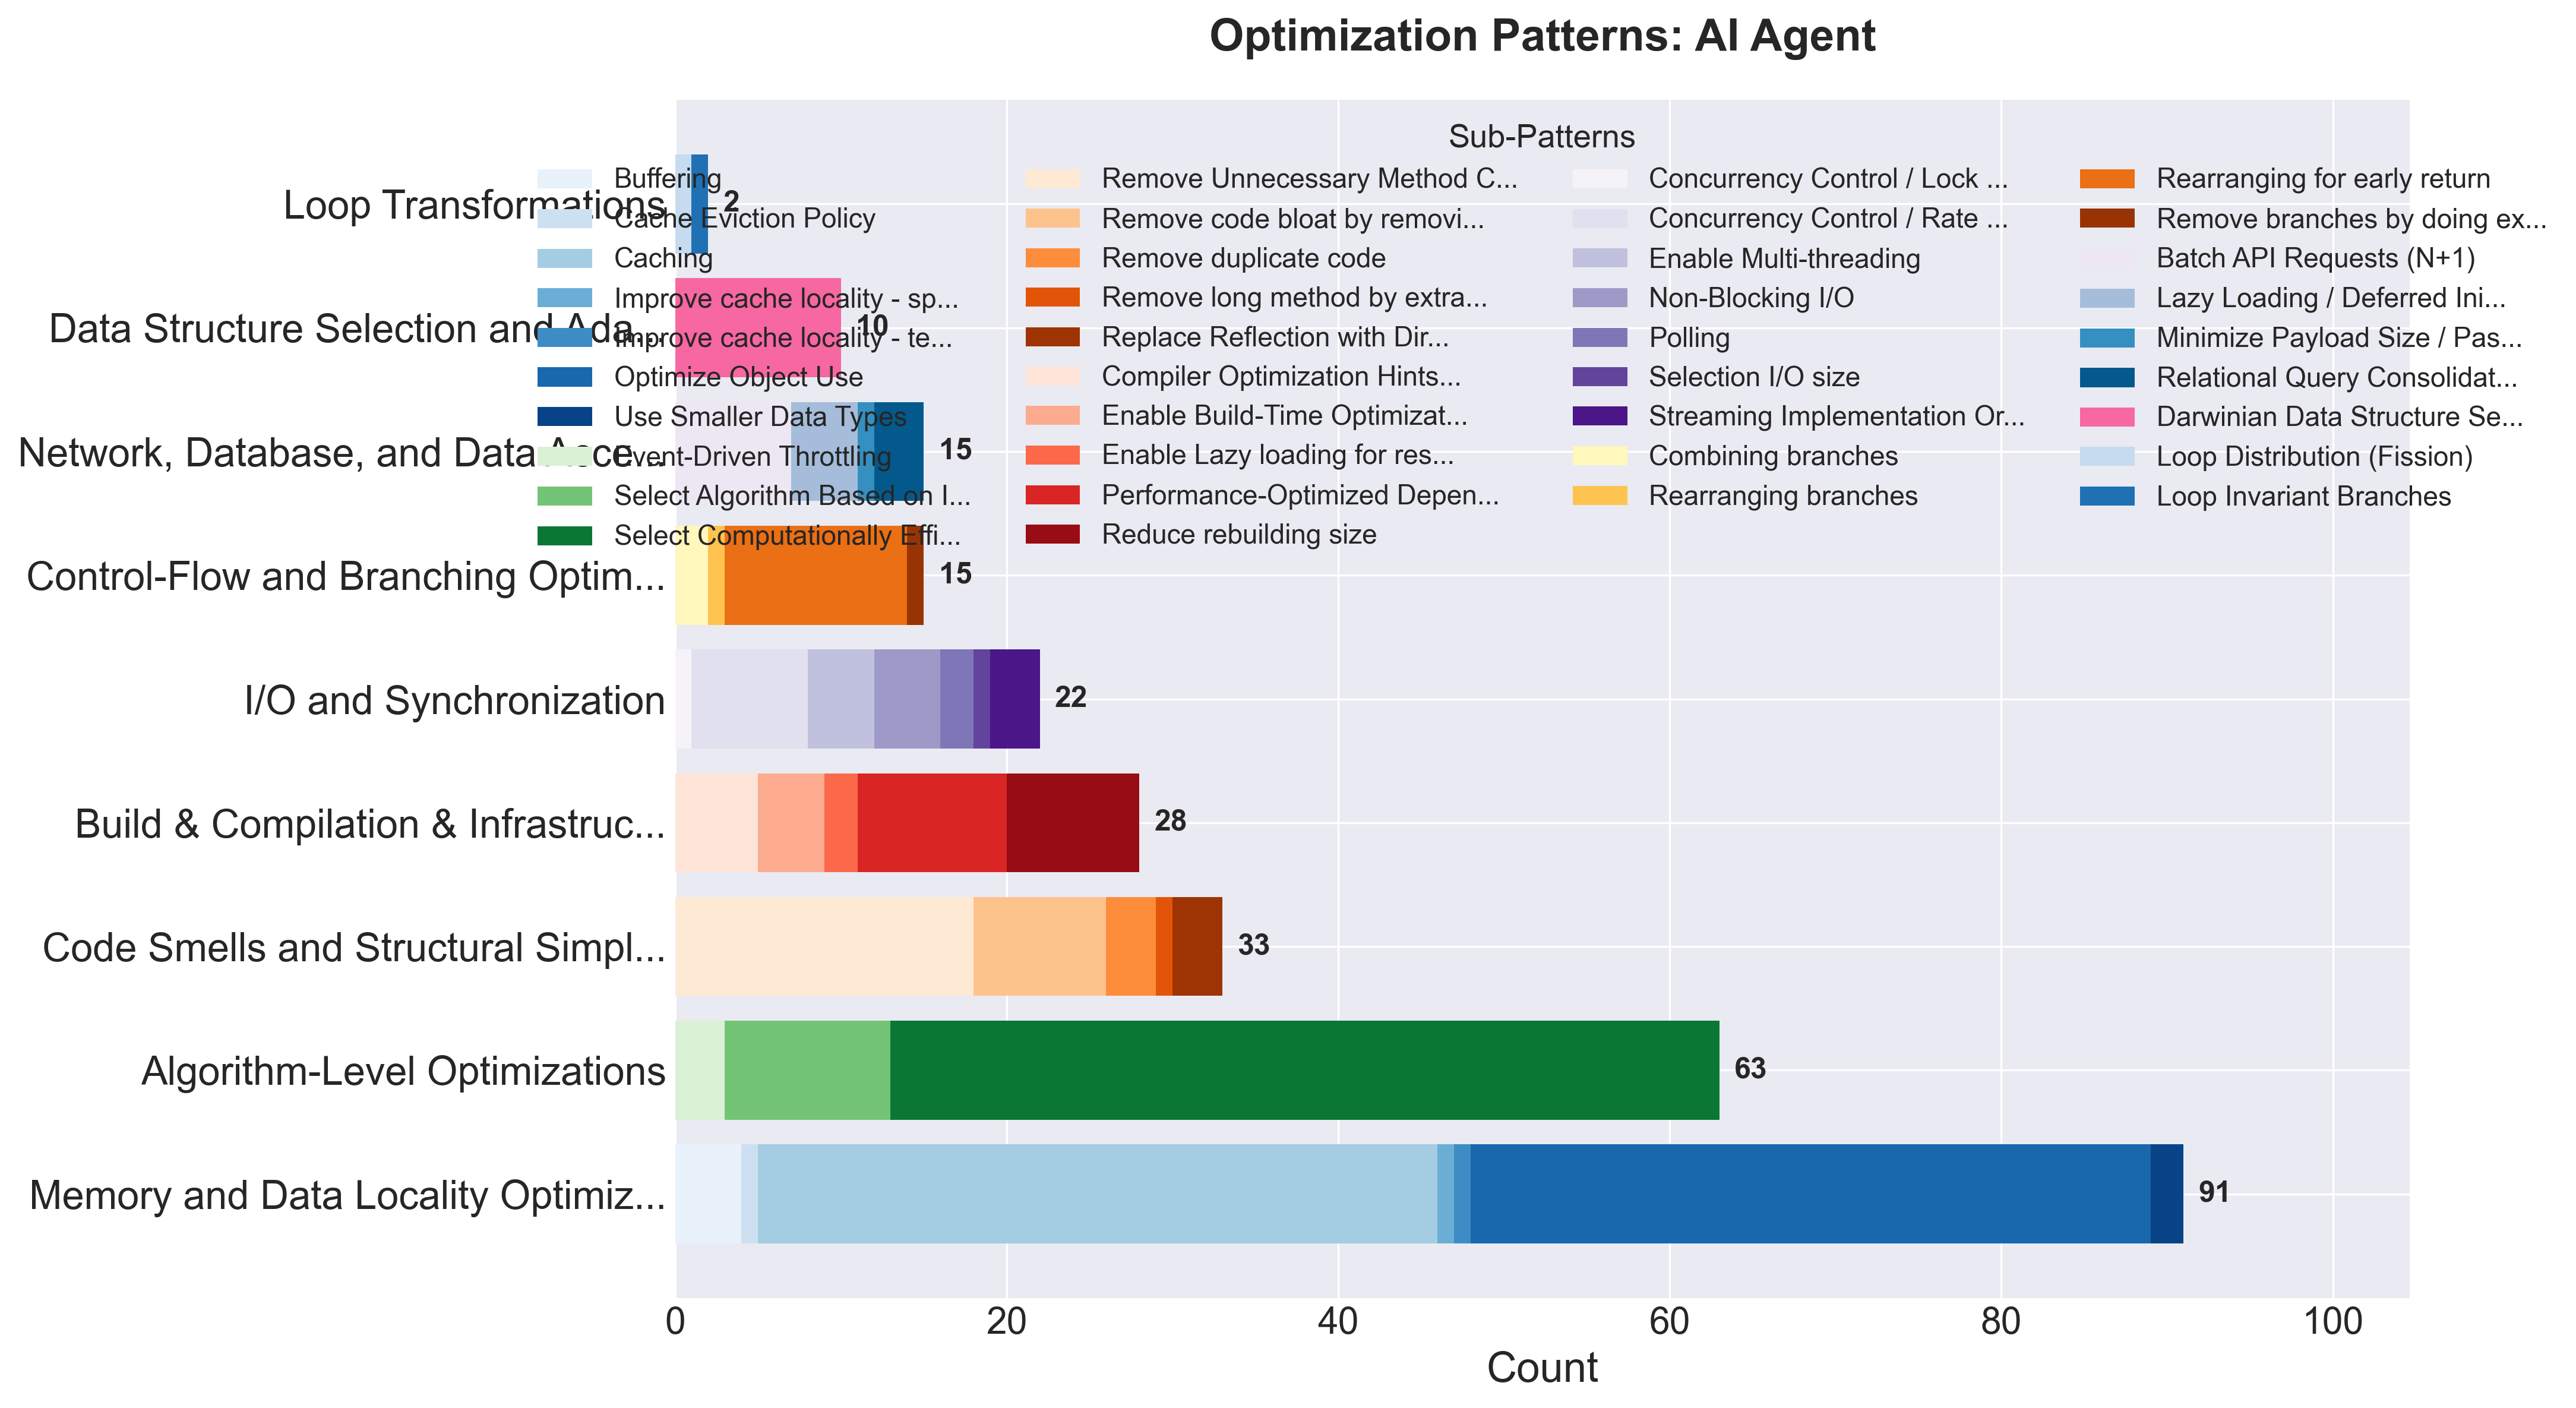

✓ Saved: ./results/optimization_pattern_ai_agent.png

2. Creating pattern-subpattern distribution for Humans...


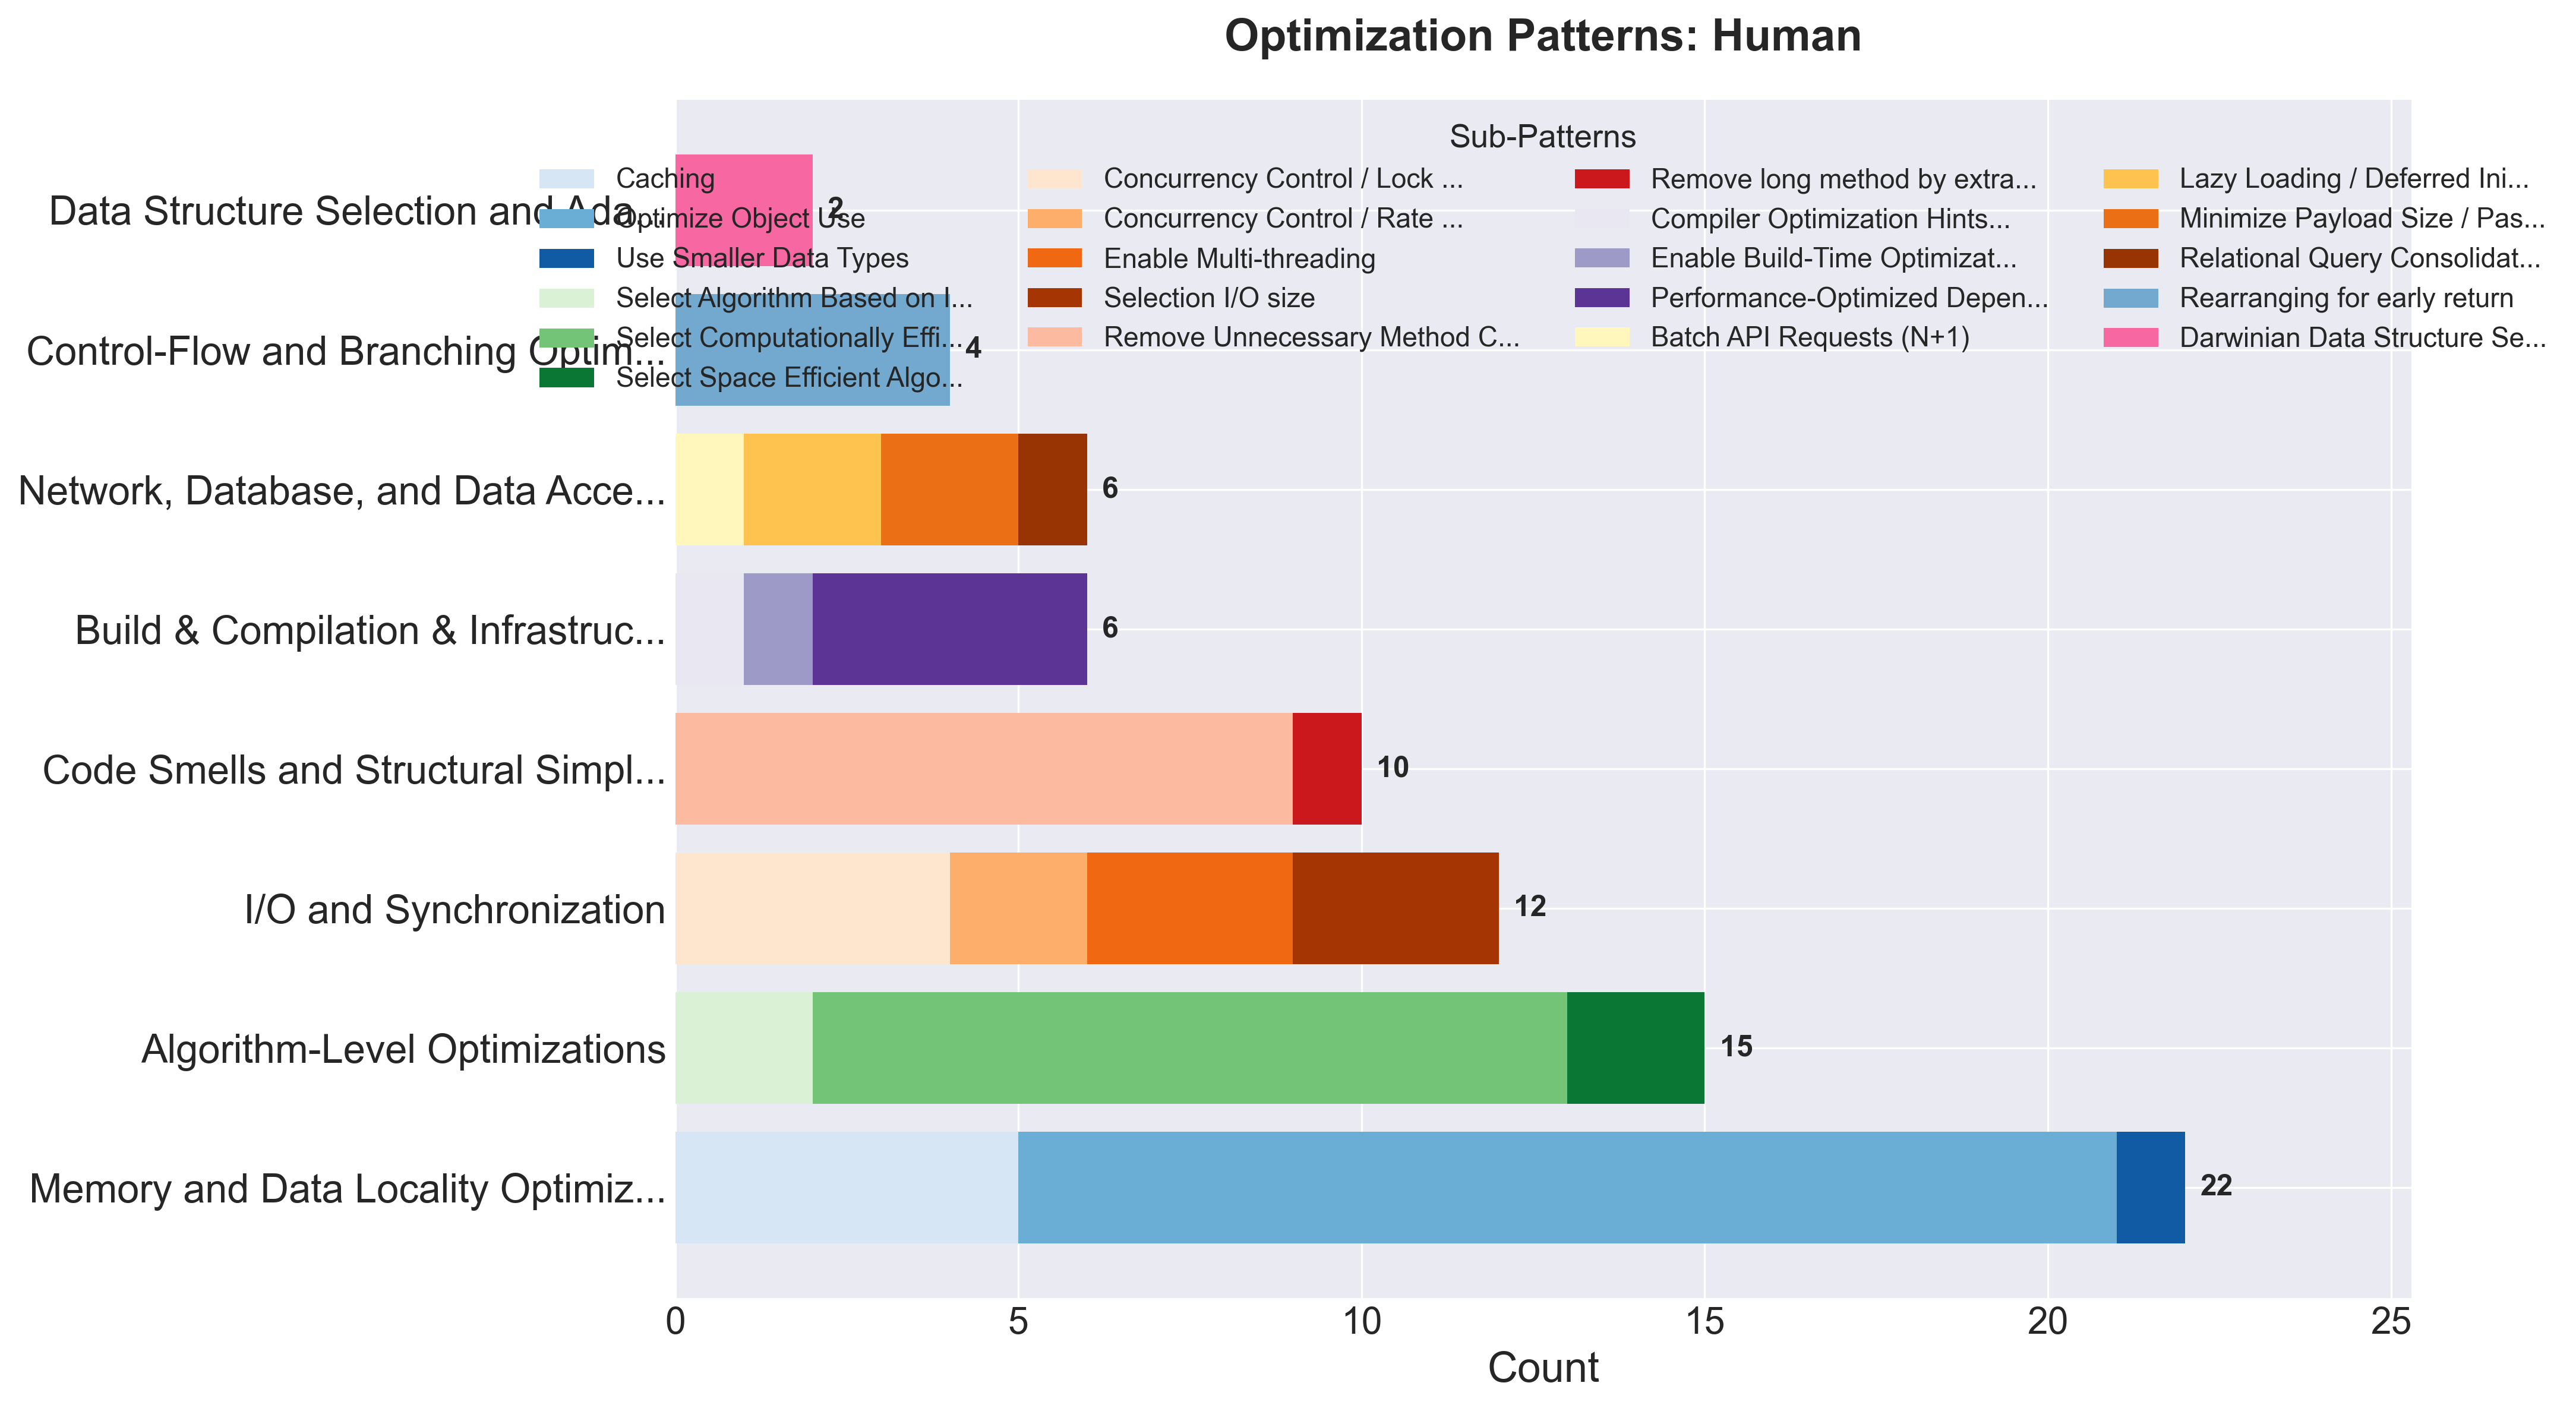

✓ Saved: ./results/optimization_pattern_human.png

✓ VISUALIZATIONS COMPLETE


In [28]:
# ============================================================================
# Visualization Script: Optimization Pattern Analysis (Revised)
# ============================================================================

import os
import textwrap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import fisher_exact

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

FINAL_COLUMNS = {
    'PR ID': 'pr_id',
    'PR URL': 'pr_url',
    'Final Pattern': 'optimization_pattern',
    'Final Sub Pattern': 'optimization_subpattern',
}


def load_final_labels(path: str, author_type: str) -> pd.DataFrame:
    """Load final label CSV and align columns with plotting helpers."""
    df = pd.read_csv(path)
    df = df.rename(columns=FINAL_COLUMNS)
    df['author_type'] = author_type
    for col in ['optimization_pattern', 'optimization_subpattern']:
        if col not in df:
            df[col] = ''
        df[col] = df[col].fillna('').str.strip()
    return df


# Load data
print("Loading data from csv files...")
agent_path = './results/Agent_PRs.csv'
human_path = './results/Human_PRs.csv'
if not (os.path.exists(agent_path) and os.path.exists(human_path)):
    raise FileNotFoundError('Required CSV files not found. Please run the label consolidation workflow first.')

ai_perf_prs_analyzed = load_final_labels(agent_path, 'AI Agent')
human_perf_prs_analyzed = load_final_labels(human_path, 'Human')

# Combine datasets
analyzed = pd.concat([ai_perf_prs_analyzed, human_perf_prs_analyzed], ignore_index=True)
analyzed = analyzed[(analyzed['optimization_pattern'] != '') & (analyzed['optimization_subpattern'] != '')]

print(f"Combined dataset: {len(analyzed):,} performance PRs")
print(f"  AI Agents: {(analyzed['author_type'] == 'AI Agent').sum():,}")
print(f"  Humans: {(analyzed['author_type'] == 'Human').sum():,}")

# ============================================================================
# Helper Functions
# ============================================================================

def wrap_labels(labels, width=30):
    """Wrap long labels for better readability"""
    return [textwrap.fill(label, width) for label in labels]


# ============================================================================
# Pattern and Sub-Pattern Distribution (Single Figure per Author Type)
# Using the same style as the provided script
# ============================================================================

def plot_pattern_subpattern_stacked(analyzed, author_type):
    """
    Create stacked horizontal bar chart showing patterns and sub-patterns
    Similar style to the provided script
    """

    # Filter by author type
    subset = analyzed[analyzed['author_type'] == author_type].copy()

    # Get pattern and sub-pattern data
    pattern_subpattern = subset.groupby(['optimization_pattern', 'optimization_subpattern']).size()

    # Build data dictionary
    data_dict = {}
    for (pattern, subpattern), count in pattern_subpattern.items():
        if pattern and subpattern:
            data_dict.setdefault(pattern, {})[subpattern] = count

    if not data_dict:
        print(f"No data available for {author_type}")
        return

    # Sort patterns by total count
    pattern_totals = {k: sum(v.values()) for k, v in data_dict.items()}
    sorted_patterns = sorted(pattern_totals.keys(), key=lambda x: pattern_totals[x], reverse=True)
    data_dict = {k: data_dict[k] for k in sorted_patterns if k in data_dict}

    # Short labels for patterns (y-axis)
    short_labels = {}
    for pattern in data_dict.keys():
        short_labels[pattern] = pattern[:32] + '...' if len(pattern) > 35 else pattern

    # Short labels for sub-patterns (legend)
    sub_short = {}
    for pattern, subs in data_dict.items():
        for sub in subs.keys():
            sub_short[sub] = sub[:27] + '...' if len(sub) > 30 else sub

    # Color maps for each category (cycling through different colormaps)
    available_colormaps = ['Blues', 'Greens', 'Oranges', 'Reds', 'Purples', 'YlOrBr', 'PuBu', 'RdPu']
    colormaps = {}
    for idx, pattern in enumerate(data_dict.keys()):
        num_subs = len(data_dict[pattern])
        colormaps[pattern] = (available_colormaps[idx % len(available_colormaps)], num_subs)

    # Flatten subpatterns
    subpatterns = []
    for cat, sub in data_dict.items():
        for sp in sub.keys():
            subpatterns.append((cat, sp))

    # Build DataFrame
    rows = []
    for cat in data_dict.keys():
        row = [data_dict[cat].get(sp, 0) for _, sp in subpatterns]
        rows.append(row)

    df = pd.DataFrame(rows,
                      index=list(data_dict.keys()),
                      columns=[sp for _, sp in subpatterns])

    # Generate colors by category
    colors = []
    for cat, sp in subpatterns:
        cmap_name, count = colormaps[cat]
        cmap = plt.get_cmap(cmap_name)
        idx = list(data_dict[cat].keys()).index(sp)
        colors.append(cmap((idx + 0.5) / max(count, 1)))

    # Plot
    fig, ax = plt.subplots(figsize=(14, max(8, len(data_dict) * 0.6)))
    left = np.zeros(len(df))
    y_labels = [short_labels[cat] for cat in df.index]

    for i, (_, sp) in enumerate(subpatterns):
        ax.barh(y_labels, df.iloc[:, i], left=left,
                label=sub_short[sp], color=colors[i])
        left += df.iloc[:, i].values

    # Add total counts
    totals = df.sum(axis=1).values
    for i, total in enumerate(totals):
        ax.text(total + max(totals) * 0.01, i, str(int(total)),
                va='center', fontsize=12, fontweight='bold')

    # Final styling
    ax.set_xlabel('Count', fontsize=17)
    ax.set_title(f'Optimization Patterns: {author_type}', fontsize=18, fontweight='bold', pad=20)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=15)
    ax.set_xlim(0, max(totals) * 1.15)

    # Legend at top center
    ncol = min(4, (len(subpatterns) + 2) // 3)
    legend = ax.legend(title='Sub-Patterns',
                       loc='upper center',
                       bbox_to_anchor=(0.5, 1.0),
                       ncol=ncol,
                       framealpha=0.9,
                       fontsize=11,
                       title_fontsize=13)
    legend.get_frame().set_edgecolor('gray')
    legend.get_frame().set_linewidth(0.5)

    plt.tight_layout()

    # Save
    filename = f'./results/optimization_pattern_{author_type.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved: {filename}")


# ============================================================================
# Summary Statistics
# ============================================================================

def print_summary_statistics(analyzed):
    """Print summary statistics"""

    print("\n" + "=" * 80)
    print("OPTIMIZATION PATTERN ANALYSIS SUMMARY")
    print("=" * 80)
    print(f"\nTotal PRs Analyzed: {len(analyzed):,}")
    print(f"  AI Agents: {(analyzed['author_type'] == 'AI Agent').sum():,}")
    print(f"  Humans: {(analyzed['author_type'] == 'Human').sum():,}")

    print(f"\nUnique Patterns: {analyzed['optimization_pattern'].nunique()}")
    print(f"Unique Sub-Patterns: {analyzed['optimization_subpattern'].nunique()}")

    print("\n" + "-" * 80)
    print("TOP 5 PATTERNS (OVERALL)")
    print("-" * 80)
    top_patterns = analyzed['optimization_pattern'].value_counts().head(5)
    for pattern, count in top_patterns.items():
        pct = count / len(analyzed) * 100
        print(f"  {pattern[:60]:60s} {count:4d} ({pct:5.1f}%)")

    print("\n" + "-" * 80)
    print("TOP 5 PATTERNS (AI AGENTS)")
    print("-" * 80)
    ai_subset = analyzed[analyzed['author_type'] == 'AI Agent']
    top_ai = ai_subset['optimization_pattern'].value_counts().head(5)
    for pattern, count in top_ai.items():
        pct = count / len(ai_subset) * 100
        print(f"  {pattern[:60]:60s} {count:4d} ({pct:5.1f}%)")

    print("\n" + "-" * 80)
    print("TOP 5 PATTERNS (HUMANS)")
    print("-" * 80)
    human_subset = analyzed[analyzed['author_type'] == 'Human']
    top_human = human_subset['optimization_pattern'].value_counts().head(5)
    for pattern, count in top_human.items():
        pct = count / len(human_subset) * 100
        print(f"  {pattern[:60]:60s} {count:4d} ({pct:5.1f}%)")

    print("\n" + "=" * 80)


# ============================================================================
# Main Execution
# ============================================================================

def generate_all_visualizations():
    """Generate the summary statistics and stacked pattern views"""

    print("\n" + "=" * 80)
    print("GENERATING VISUALIZATIONS")
    print("=" * 80)

    # Print summary statistics
    print_summary_statistics(analyzed)

    print("\n1. Creating pattern-subpattern distribution for AI Agents...")
    plot_pattern_subpattern_stacked(analyzed, 'AI Agent')

    print("\n2. Creating pattern-subpattern distribution for Humans...")
    plot_pattern_subpattern_stacked(analyzed, 'Human')

    print("\n" + "=" * 80)
    print("✓ VISUALIZATIONS COMPLETE")
    print("=" * 80)


# Run visualizations
generate_all_visualizations()



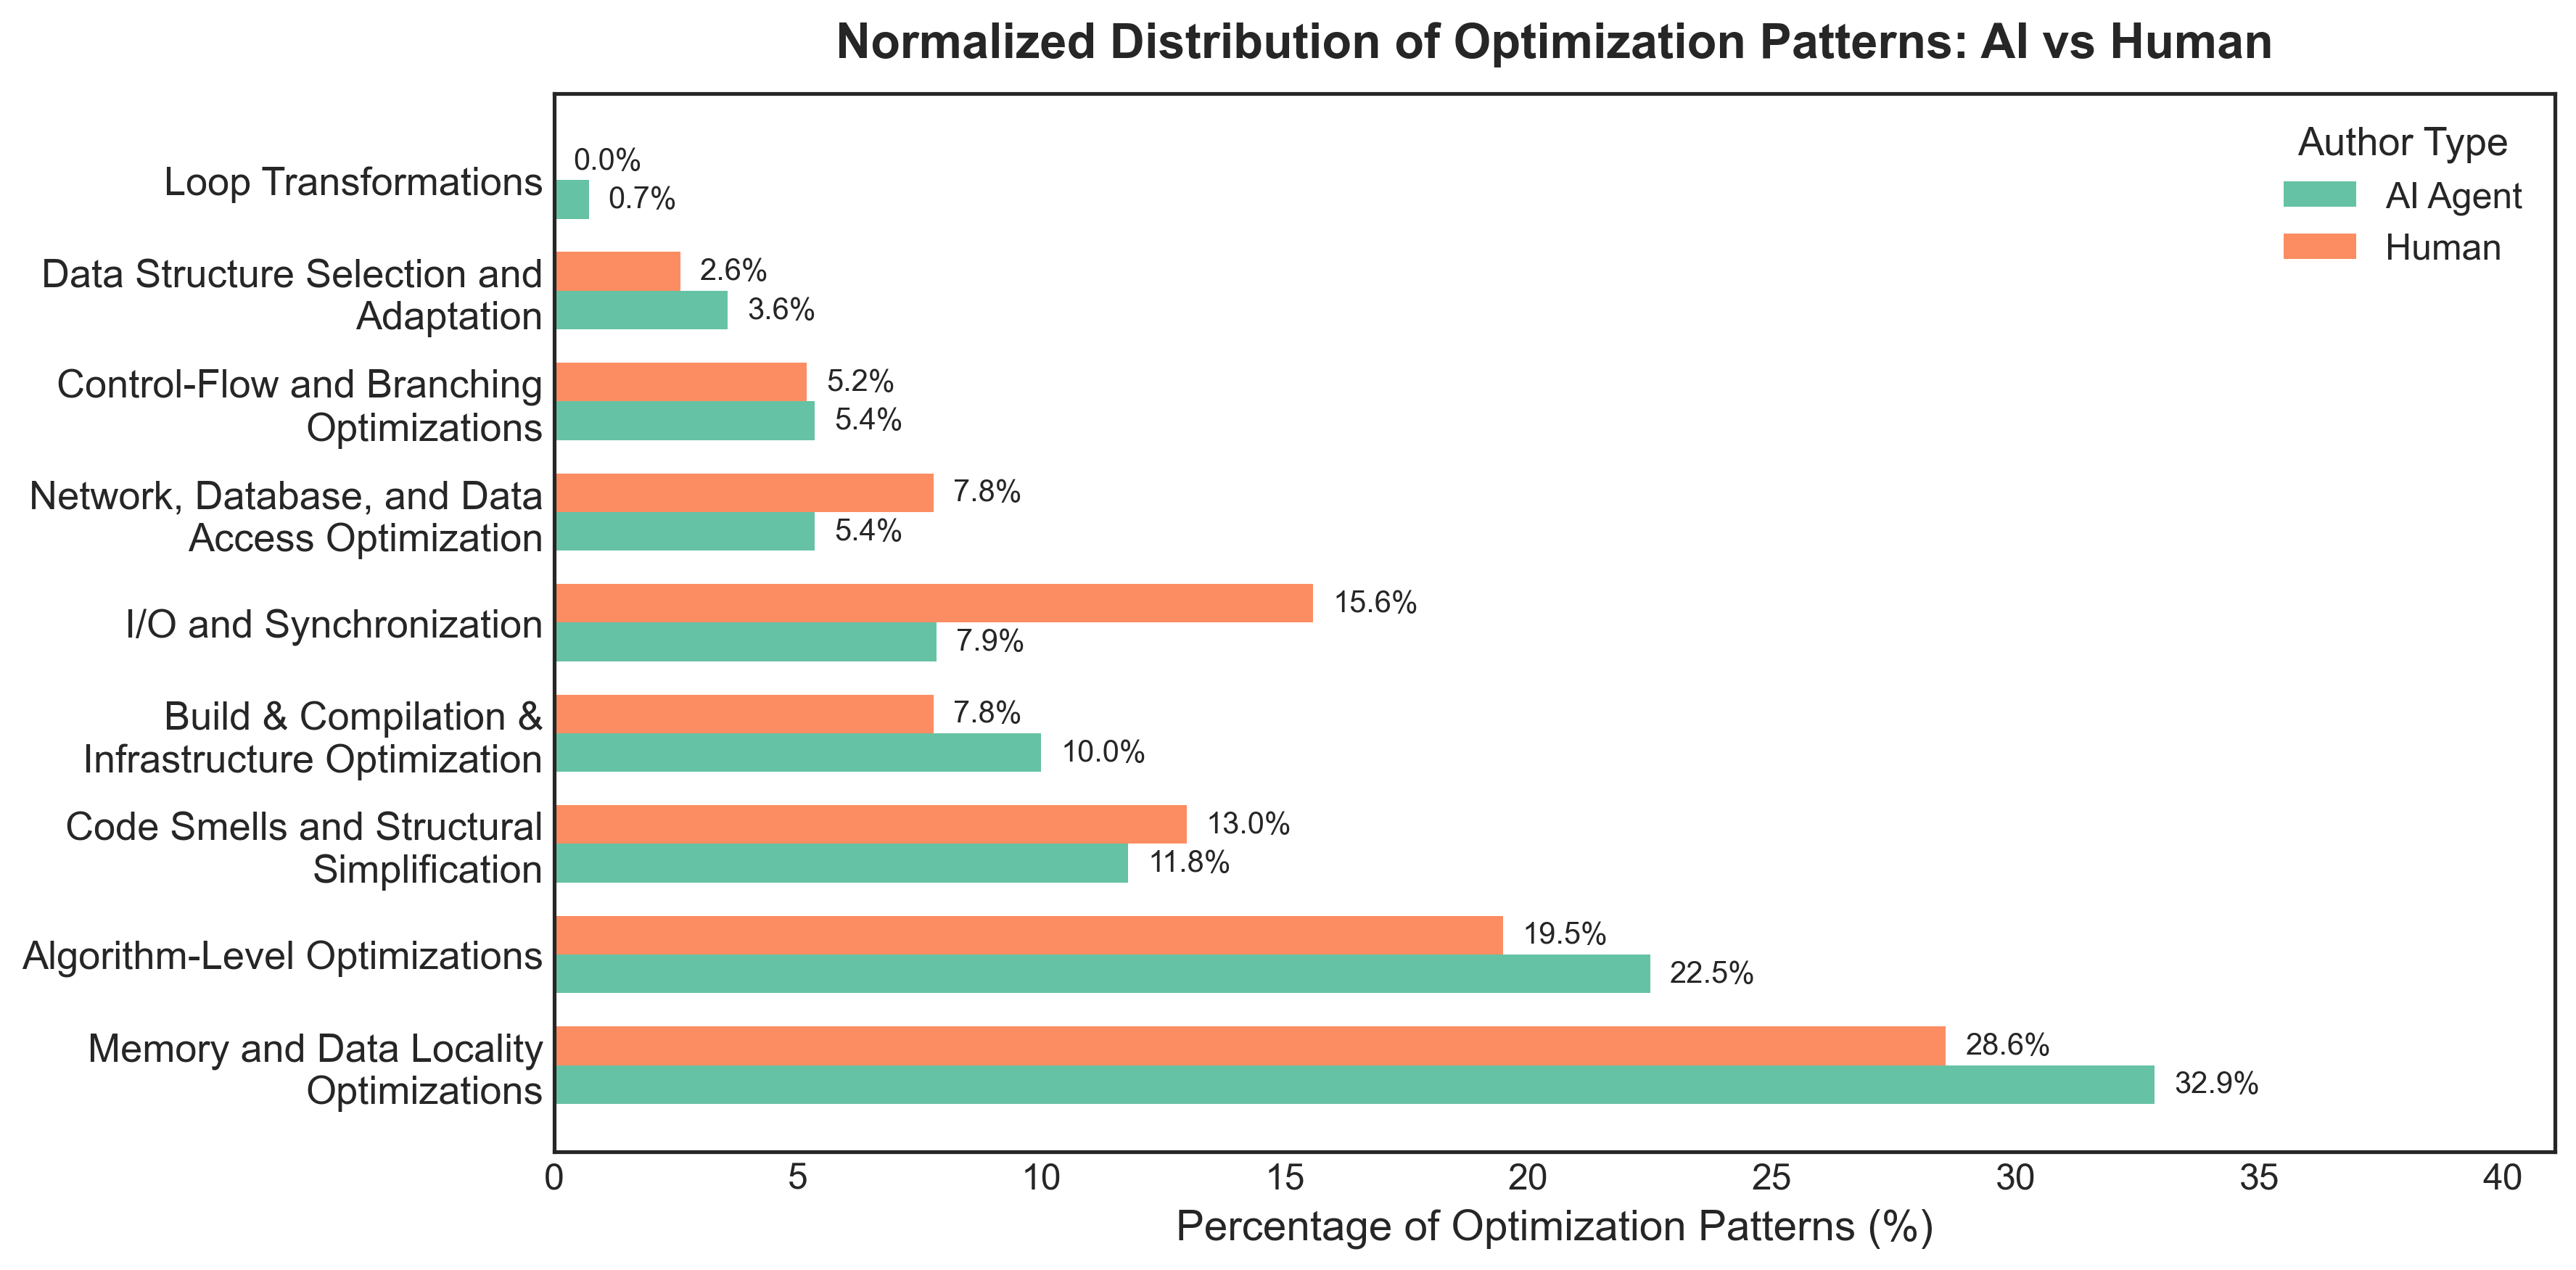

✓ Saved: normalized_patterns_grouped_ai_vs_human_no_nonperf.png


In [55]:
# ============================================================================
# Normalized Pattern Distribution (Percentages) — Grouped Bars
# AI vs Human (EXCLUDING non-performance PRs)
# ============================================================================

import os
import textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------------------------
# Style (WHITE background, NO grid)
# ----------------------------------------------------------------------------
plt.style.use('seaborn-v0_8-white')
sns.set_palette("Set2")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 12

FINAL_COLUMNS = {
    'PR ID': 'pr_id',
    'PR URL': 'pr_url',
    'Final Pattern': 'optimization_pattern',
}

# ----------------------------------------------------------------------------
# Load data
# ----------------------------------------------------------------------------
def load_final_labels(path, author_type):
    df = pd.read_csv(path)
    df = df.rename(columns=FINAL_COLUMNS)
    df['author_type'] = author_type
    df['optimization_pattern'] = df['optimization_pattern'].fillna('').str.strip()
    return df

# ----------------------------------------------------------------------------
# Plot grouped normalized bars (exclude non-perf)
# ----------------------------------------------------------------------------
def plot_grouped_normalized_patterns(analyzed):
    EXCLUDE_PATTERNS = {
        'No Meaningful Change or Not Performance PR'
    }

    analyzed = analyzed[
        ~analyzed['optimization_pattern'].isin(EXCLUDE_PATTERNS)
    ]

    # Count per author & pattern
    counts = (
        analyzed
        .groupby(['author_type', 'optimization_pattern'])
        .size()
        .reset_index(name='count')
    )

    # Normalize within author
    totals = counts.groupby('author_type')['count'].sum().to_dict()
    counts['percent'] = counts.apply(
        lambda r: 100 * r['count'] / totals[r['author_type']],
        axis=1
    )

    pivot = counts.pivot(
        index='optimization_pattern',
        columns='author_type',
        values='percent'
    ).fillna(0)

    # Global ordering
    order = (
        analyzed
        .groupby('optimization_pattern')
        .size()
        .sort_values(ascending=False)
        .index
    )
    pivot = pivot.loc[order]

    labels = [textwrap.fill(p, 32) for p in pivot.index]

    y = np.arange(len(pivot))
    bar_h = 0.35

    fig, ax = plt.subplots(figsize=(12, max(6, len(pivot) * 0.6)))

    ax.barh(
        y - bar_h / 2,
        pivot.get('AI Agent', 0),
        height=bar_h,
        label='AI Agent'
    )
    ax.barh(
        y + bar_h / 2,
        pivot.get('Human', 0),
        height=bar_h,
        label='Human'
    )

    # Remove grid explicitly
    ax.grid(False)

    # Value labels
    for i, (ai, hu) in enumerate(
        zip(pivot.get('AI Agent', []), pivot.get('Human', []))
    ):
        ax.text(ai + 0.4, i - bar_h / 2, f"{ai:.1f}%", va='center', fontsize=10)
        ax.text(hu + 0.4, i + bar_h / 2, f"{hu:.1f}%", va='center', fontsize=10)

    ax.set_yticks(y)
    ax.set_yticklabels(labels, fontsize=13)
    ax.set_xlim(0, max(pivot.max()) * 1.25)
    ax.set_xlabel("Percentage of Optimization Patterns (%)", fontsize=14)

    ax.set_title(
        "Normalized Distribution of Optimization Patterns: AI vs Human",
        fontsize=16,
        fontweight='bold',
        pad=12
    )

    ax.legend(title="Author Type", fontsize=12, title_fontsize=13)

    plt.tight_layout()

    os.makedirs("./results", exist_ok=True)
    plt.savefig(
        "./results/normalized_patterns_grouped_ai_vs_human_no_nonperf.png",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()

    print("✓ Saved: normalized_patterns_grouped_ai_vs_human_no_nonperf.png")

# ----------------------------------------------------------------------------
# Main
# ----------------------------------------------------------------------------
def main():
    ai = load_final_labels("./results/Agent_PRs.csv", "AI Agent")
    hu = load_final_labels("./results/Human_PRs.csv", "Human")

    analyzed = pd.concat([ai, hu], ignore_index=True)
    analyzed = analyzed[analyzed['optimization_pattern'] != ""]

    plot_grouped_normalized_patterns(analyzed)

if __name__ == "__main__":
    main()


In [54]:
# ============================================================================
# Comprehensive Diversity Analysis of Optimization Sub-patterns
# AI vs Human — All Valid Statistical Tests
# ============================================================================

import numpy as np
import pandas as pd
from collections import Counter

# ----------------------------------------------------------------------------
# Config
# ----------------------------------------------------------------------------
FINAL_COLUMNS = {
    'PR ID': 'pr_id',
    'Final Pattern': 'optimization_pattern',
    'Final Sub Pattern': 'optimization_subpattern',
}

EXCLUDE_PATTERNS = {'No Meaningful Change or Not Performance PR'}
N_PERM = 20000
SEED = 0

rng = np.random.default_rng(SEED)

# ----------------------------------------------------------------------------
# Load + clean
# ----------------------------------------------------------------------------
def load_final_labels(path, author_type):
    df = pd.read_csv(path).rename(columns=FINAL_COLUMNS)
    df['author_type'] = author_type
    df['optimization_pattern'] = df['optimization_pattern'].fillna('').str.strip()
    df['optimization_subpattern'] = df['optimization_subpattern'].fillna('').str.strip()
    return df

def prepare(df):
    return (
        df[
            (df['optimization_pattern'] != '') &
            (df['optimization_subpattern'] != '') &
            (~df['optimization_pattern'].isin(EXCLUDE_PATTERNS))
        ]
        .drop_duplicates(subset=['pr_id'])
        .reset_index(drop=True)
    )

# ----------------------------------------------------------------------------
# Test 1: Richness (unique sub-patterns) — permutation
# ----------------------------------------------------------------------------
def richness_permutation(df_all, n_ai, n_hu):
    subs = df_all['optimization_subpattern'].to_numpy()
    labels = df_all['author_type'].to_numpy()

    obs_ai = len(set(subs[labels == 'AI Agent']))
    obs_hu = len(set(subs[labels == 'Human']))
    obs_diff = obs_ai - obs_hu

    idx = np.arange(len(subs))
    diffs = np.empty(N_PERM)

    for i in range(N_PERM):
        perm = rng.permutation(idx)
        ai_idx = perm[:n_ai]
        hu_idx = perm[n_ai:n_ai + n_hu]
        diffs[i] = len(set(subs[ai_idx])) - len(set(subs[hu_idx]))

    p = (np.sum(np.abs(diffs) >= abs(obs_diff)) + 1) / (N_PERM + 1)
    return obs_ai, obs_hu, obs_diff, p

# ----------------------------------------------------------------------------
# Test 2: Rarefaction (correct tail)
# ----------------------------------------------------------------------------
def rarefaction_test(ai_df, hu_df):
    ai_sub = ai_df['optimization_subpattern'].to_numpy()
    hu_sub = hu_df['optimization_subpattern'].to_numpy()
    n_hu = len(hu_df)

    hu_unique = len(set(hu_sub))
    ai_uniques = np.empty(N_PERM, dtype=int)

    for i in range(N_PERM):
        sample = rng.choice(ai_sub, size=n_hu, replace=False)
        ai_uniques[i] = len(set(sample))

    p = (np.sum(ai_uniques <= hu_unique) + 1) / (N_PERM + 1)
    return hu_unique, np.median(ai_uniques), p


# ----------------------------------------------------------------------------
# Main
# ----------------------------------------------------------------------------
def main():
    ai = prepare(load_final_labels("./results/Agent_PRs.csv", "AI Agent"))
    hu = prepare(load_final_labels("./results/Human_PRs.csv", "Human"))

    print(f"AI PRs: {len(ai)} | Human PRs: {len(hu)}")

    df_all = pd.concat([ai, hu], ignore_index=True)

    # Test 1
    r_ai, r_hu, r_diff, r_p = richness_permutation(df_all, len(ai), len(hu))
    print("\n[Richness / Permutation]")
    print(f"AI={r_ai}, Human={r_hu}, Diff={r_diff}, p={r_p:.4f}")

    # Test 2
    hu_u, ai_med, p_rare = rarefaction_test(ai, hu)
    print("\n[Rarefaction]")
    print(f"Human unique={hu_u}, AI median={ai_med}, p={p_rare:.4f}")


if __name__ == "__main__":
    main()


AI PRs: 280 | Human PRs: 77

[Richness / Permutation]
AI=38, Human=21, Diff=17, p=0.1223

[Rarefaction]
Human unique=21, AI median=24.0, p=0.1329


In [27]:
target_label = 'No Meaningful Change or Not Performance PR'
label_mask = analyzed['optimization_pattern'] == target_label
counts = analyzed[label_mask].groupby('author_type').size()
ai_nmc = int(counts.get('AI Agent', 0))
human_nmc = int(counts.get('Human', 0))
ai_total = int((analyzed['author_type'] == 'AI Agent').sum())
human_total = int((analyzed['author_type'] == 'Human').sum())
contingency = np.array([
    [ai_nmc, ai_total - ai_nmc],
    [human_nmc, human_total - human_nmc],
])
odds_ratio, p_value = fisher_exact(contingency)
ai_rate = ai_nmc / ai_total if ai_total else 0
human_rate = human_nmc / human_total if human_total else 0

print(f'"{target_label}" counts:')
print(f'  AI Agents : {ai_nmc} / {ai_total} ({ai_rate:.2%})')
print(f'  Humans    : {human_nmc} / {human_total} ({human_rate:.2%})')


"No Meaningful Change or Not Performance PR" counts:
  AI Agents : 44 / 324 (13.58%)
  Humans    : 6 / 83 (7.23%)
